Run this notebook using the ``mncnh_sim`` environment

In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd, numpy as np, os
from vivarium import Artifact
import scipy.stats as stats
import scipy
from pathlib import Path

from ifa_gestational_age_shifts import lognorm_from_median_lower_upper, run_all_locations, load_mms_data, mms_shift, mms_double_shift, mms_run_all_locations, LOCATION_DATA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IFA/MMS Gestational Age Shift Calculation
Adapted from https://github.com/ihmeuw/vivarium_research_nutrition_optimization/blob/data_prep/data_prep/antenatal_interventions/Gestational%20age%20shifts.ipynb


For refactor, load LBWSG exposure from interactive sim without IV iron intervention

NOTE: The interactive sim is run below using a custom model spec with the oral iron intervention REMOVED.

In [7]:
! pip list | grep vivarium

vivarium                  3.6.3
vivarium_build_utils      2.0.13
vivarium_cluster_tools    2.1.25
vivarium_dependencies     1.0.1
vivarium_gates_mncnh      23.1.dev5+g49a87cb0b /mnt/share/homes/tylerdy/vivarium_gates_mncnh
vivarium_public_health    4.3.14
vivarium_testing_utils    0.2.6


In [8]:
! pip freeze | grep vivarium

vivarium==3.6.3
vivarium_build_utils==2.0.13
vivarium_cluster_tools==2.1.25
vivarium_dependencies==1.0.1
-e git+https://github.com/ihmeuw/vivarium_gates_mncnh.git@3a736026e7efe04a881c11e8b37e45a63a2202af#egg=vivarium_gates_mncnh
vivarium_public_health==4.3.14
vivarium_testing_utils==0.2.6


In [55]:
# list of available draws 
draws_to_run = [115, 60, 118, 197, 79, 244, 22, 167, 146, 71,
    28, 156, 94, 170, 109, 26, 35, 114, 178, 127
]

In [16]:
ifa_shifts, exp_anc = run_all_locations(draws_to_run)

2026-01-27 11:27:20.963 | INFO     | simulation_13-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:27:20.965 | INFO     | simulation_13-artifact_manager:80 - Artifact base filter terms are ['draw == 28'].
2026-01-27 11:27:20.966 | INFO     | simulation_13-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:27:47.432 | WARNING  | simulation_13-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']
2026-01-27 11:27:47.435 | WARNING  | simulation_13-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']
2026-01-27 11:27:47.616 | WARNING  | simulation_13-values_manager:55 - Unsourced pipelines: ['iron_folic_acid_supplementation.exposure', 'multiple_micronutrient_supplementation.exposure']
2026-01-27 1

2026-01-27 11:27:49.283 | INFO     | simulation_13 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:27:50.750 | INFO     | simulation_13 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:27:51.818 | INFO     | simulation_13 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:27:52.576 | INFO     | simulation_13 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:28:00.995 | INFO     | simulation_14-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:28:00.996 | INFO     | simulation_14-artifact_manager:80 - Artifact base filter terms are ['draw == 156'].
2026-01-27 11:28:00.997 | INFO     | simulation_14-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:28:26.260 | WARNING  | simulation_14-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:28:27.994 | INFO     | simulation_14 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:28:29.425 | INFO     | simulation_14 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:28:30.477 | INFO     | simulation_14 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:28:31.217 | INFO     | simulation_14 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:28:39.420 | INFO     | simulation_15-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:28:39.421 | INFO     | simulation_15-artifact_manager:80 - Artifact base filter terms are ['draw == 94'].
2026-01-27 11:28:39.422 | INFO     | simulation_15-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:29:05.630 | WARNING  | simulation_15-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:29:07.505 | INFO     | simulation_15 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:29:09.234 | INFO     | simulation_15 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:29:10.436 | INFO     | simulation_15 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:29:11.222 | INFO     | simulation_15 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:29:20.551 | INFO     | simulation_16-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:29:20.552 | INFO     | simulation_16-artifact_manager:80 - Artifact base filter terms are ['draw == 170'].
2026-01-27 11:29:20.553 | INFO     | simulation_16-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:29:46.009 | WARNING  | simulation_16-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:29:47.759 | INFO     | simulation_16 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:29:49.582 | INFO     | simulation_16 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:29:50.790 | INFO     | simulation_16 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:29:51.622 | INFO     | simulation_16 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:30:00.105 | INFO     | simulation_17-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:30:00.108 | INFO     | simulation_17-artifact_manager:80 - Artifact base filter terms are ['draw == 109'].
2026-01-27 11:30:00.108 | INFO     | simulation_17-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:30:25.305 | WARNING  | simulation_17-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:30:27.089 | INFO     | simulation_17 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:30:28.524 | INFO     | simulation_17 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:30:29.604 | INFO     | simulation_17 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:30:30.349 | INFO     | simulation_17 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:30:39.199 | INFO     | simulation_18-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:30:39.199 | INFO     | simulation_18-artifact_manager:80 - Artifact base filter terms are ['draw == 26'].
2026-01-27 11:30:39.200 | INFO     | simulation_18-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:31:04.314 | WARNING  | simulation_18-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:31:06.159 | INFO     | simulation_18 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:31:07.611 | INFO     | simulation_18 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:31:08.664 | INFO     | simulation_18 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:31:09.409 | INFO     | simulation_18 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:31:17.888 | INFO     | simulation_19-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:31:17.889 | INFO     | simulation_19-artifact_manager:80 - Artifact base filter terms are ['draw == 35'].
2026-01-27 11:31:17.890 | INFO     | simulation_19-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:31:43.245 | WARNING  | simulation_19-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:31:45.000 | INFO     | simulation_19 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:31:46.433 | INFO     | simulation_19 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:31:47.504 | INFO     | simulation_19 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:31:48.246 | INFO     | simulation_19 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:31:55.906 | INFO     | simulation_20-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:31:55.907 | INFO     | simulation_20-artifact_manager:80 - Artifact base filter terms are ['draw == 114'].
2026-01-27 11:31:55.908 | INFO     | simulation_20-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:32:20.918 | WARNING  | simulation_20-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:32:22.687 | INFO     | simulation_20 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:32:24.110 | INFO     | simulation_20 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:32:25.159 | INFO     | simulation_20 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:32:25.906 | INFO     | simulation_20 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:32:33.677 | INFO     | simulation_21-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:32:33.678 | INFO     | simulation_21-artifact_manager:80 - Artifact base filter terms are ['draw == 178'].
2026-01-27 11:32:33.679 | INFO     | simulation_21-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:32:59.028 | WARNING  | simulation_21-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:33:00.763 | INFO     | simulation_21 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:33:02.179 | INFO     | simulation_21 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:33:03.234 | INFO     | simulation_21 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:33:03.972 | INFO     | simulation_21 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:33:12.118 | INFO     | simulation_22-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/ethiopia.hdf.
2026-01-27 11:33:12.119 | INFO     | simulation_22-artifact_manager:80 - Artifact base filter terms are ['draw == 127'].
2026-01-27 11:33:12.119 | INFO     | simulation_22-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:33:37.316 | WARNING  | simulation_22-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:33:39.209 | INFO     | simulation_22 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:33:40.629 | INFO     | simulation_22 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:33:41.693 | INFO     | simulation_22 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:33:42.430 | INFO     | simulation_22 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:33:54.985 | INFO     | simulation_23-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:33:54.986 | INFO     | simulation_23-artifact_manager:80 - Artifact base filter terms are ['draw == 28'].
2026-01-27 11:33:54.987 | INFO     | simulation_23-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:34:22.705 | WARNING  | simulation_23-results_manager:446 - Specified excluded stratifications are already not included 

2026-01-27 11:34:24.466 | INFO     | simulation_23 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:34:25.931 | INFO     | simulation_23 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:34:26.988 | INFO     | simulation_23 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:34:27.738 | INFO     | simulation_23 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:34:36.048 | INFO     | simulation_24-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:34:36.050 | INFO     | simulation_24-artifact_manager:80 - Artifact base filter terms are ['draw == 156'].
2026-01-27 11:34:36.051 | INFO     | simulation_24-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:35:03.728 | WARNING  | simulation_24-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:35:05.749 | INFO     | simulation_24 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:35:07.256 | INFO     | simulation_24 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:35:08.350 | INFO     | simulation_24 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:35:09.110 | INFO     | simulation_24 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:35:17.456 | INFO     | simulation_25-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:35:17.457 | INFO     | simulation_25-artifact_manager:80 - Artifact base filter terms are ['draw == 94'].
2026-01-27 11:35:17.458 | INFO     | simulation_25-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:35:44.367 | WARNING  | simulation_25-results_manager:446 - Specified excluded stratifications are already not included 

2026-01-27 11:35:46.127 | INFO     | simulation_25 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:35:47.570 | INFO     | simulation_25 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:35:48.650 | INFO     | simulation_25 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:35:49.429 | INFO     | simulation_25 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:35:57.796 | INFO     | simulation_26-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:35:57.797 | INFO     | simulation_26-artifact_manager:80 - Artifact base filter terms are ['draw == 170'].
2026-01-27 11:35:57.798 | INFO     | simulation_26-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:36:24.544 | WARNING  | simulation_26-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:36:26.300 | INFO     | simulation_26 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:36:27.737 | INFO     | simulation_26 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:36:28.820 | INFO     | simulation_26 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:36:29.572 | INFO     | simulation_26 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:36:37.990 | INFO     | simulation_27-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:36:37.991 | INFO     | simulation_27-artifact_manager:80 - Artifact base filter terms are ['draw == 109'].
2026-01-27 11:36:37.992 | INFO     | simulation_27-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:37:04.748 | WARNING  | simulation_27-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:37:06.521 | INFO     | simulation_27 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:37:08.031 | INFO     | simulation_27 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:37:09.186 | INFO     | simulation_27 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:37:09.986 | INFO     | simulation_27 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:37:19.660 | INFO     | simulation_28-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:37:19.662 | INFO     | simulation_28-artifact_manager:80 - Artifact base filter terms are ['draw == 26'].
2026-01-27 11:37:19.663 | INFO     | simulation_28-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:37:46.234 | WARNING  | simulation_28-results_manager:446 - Specified excluded stratifications are already not included 

2026-01-27 11:37:47.994 | INFO     | simulation_28 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:37:49.476 | INFO     | simulation_28 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:37:50.563 | INFO     | simulation_28 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:37:51.338 | INFO     | simulation_28 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:37:59.511 | INFO     | simulation_29-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:37:59.512 | INFO     | simulation_29-artifact_manager:80 - Artifact base filter terms are ['draw == 35'].
2026-01-27 11:37:59.513 | INFO     | simulation_29-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:38:26.261 | WARNING  | simulation_29-results_manager:446 - Specified excluded stratifications are already not included 

2026-01-27 11:38:27.984 | INFO     | simulation_29 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:38:29.415 | INFO     | simulation_29 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:38:30.468 | INFO     | simulation_29 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:38:31.212 | INFO     | simulation_29 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:38:39.425 | INFO     | simulation_30-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:38:39.426 | INFO     | simulation_30-artifact_manager:80 - Artifact base filter terms are ['draw == 114'].
2026-01-27 11:38:39.427 | INFO     | simulation_30-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:39:05.986 | WARNING  | simulation_30-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:39:07.807 | INFO     | simulation_30 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:39:09.436 | INFO     | simulation_30 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:39:10.506 | INFO     | simulation_30 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:39:11.266 | INFO     | simulation_30 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:39:19.548 | INFO     | simulation_31-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:39:19.549 | INFO     | simulation_31-artifact_manager:80 - Artifact base filter terms are ['draw == 178'].
2026-01-27 11:39:19.549 | INFO     | simulation_31-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:39:47.858 | WARNING  | simulation_31-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:39:49.656 | INFO     | simulation_31 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:39:51.112 | INFO     | simulation_31 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:39:52.181 | INFO     | simulation_31 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:39:52.935 | INFO     | simulation_31 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:40:01.792 | INFO     | simulation_32-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/nigeria.hdf.
2026-01-27 11:40:01.793 | INFO     | simulation_32-artifact_manager:80 - Artifact base filter terms are ['draw == 127'].
2026-01-27 11:40:01.793 | INFO     | simulation_32-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:40:29.653 | WARNING  | simulation_32-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:40:31.393 | INFO     | simulation_32 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:40:32.819 | INFO     | simulation_32 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:40:33.873 | INFO     | simulation_32 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:40:34.818 | INFO     | simulation_32 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:40:47.346 | INFO     | simulation_33-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:40:47.349 | INFO     | simulation_33-artifact_manager:80 - Artifact base filter terms are ['draw == 28'].
2026-01-27 11:40:47.350 | INFO     | simulation_33-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:41:13.982 | WARNING  | simulation_33-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:41:15.699 | INFO     | simulation_33 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:41:17.111 | INFO     | simulation_33 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:41:18.225 | INFO     | simulation_33 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:41:18.968 | INFO     | simulation_33 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:41:28.931 | INFO     | simulation_34-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:41:28.932 | INFO     | simulation_34-artifact_manager:80 - Artifact base filter terms are ['draw == 156'].
2026-01-27 11:41:28.932 | INFO     | simulation_34-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:41:55.991 | WARNING  | simulation_34-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:41:57.745 | INFO     | simulation_34 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:41:59.372 | INFO     | simulation_34 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:42:00.503 | INFO     | simulation_34 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:42:01.255 | INFO     | simulation_34 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:42:11.850 | INFO     | simulation_35-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:42:11.852 | INFO     | simulation_35-artifact_manager:80 - Artifact base filter terms are ['draw == 94'].
2026-01-27 11:42:11.852 | INFO     | simulation_35-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:42:38.404 | WARNING  | simulation_35-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:42:40.176 | INFO     | simulation_35 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:42:41.824 | INFO     | simulation_35 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:42:42.964 | INFO     | simulation_35 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:42:43.720 | INFO     | simulation_35 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:42:53.956 | INFO     | simulation_36-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:42:53.958 | INFO     | simulation_36-artifact_manager:80 - Artifact base filter terms are ['draw == 170'].
2026-01-27 11:42:53.959 | INFO     | simulation_36-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:43:20.805 | WARNING  | simulation_36-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:43:22.545 | INFO     | simulation_36 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:43:23.971 | INFO     | simulation_36 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:43:25.086 | INFO     | simulation_36 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:43:25.839 | INFO     | simulation_36 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:43:36.449 | INFO     | simulation_37-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:43:36.450 | INFO     | simulation_37-artifact_manager:80 - Artifact base filter terms are ['draw == 109'].
2026-01-27 11:43:36.451 | INFO     | simulation_37-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:44:02.964 | WARNING  | simulation_37-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:44:04.691 | INFO     | simulation_37 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:44:06.318 | INFO     | simulation_37 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:44:07.441 | INFO     | simulation_37 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:44:08.190 | INFO     | simulation_37 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:44:19.066 | INFO     | simulation_38-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:44:19.067 | INFO     | simulation_38-artifact_manager:80 - Artifact base filter terms are ['draw == 26'].
2026-01-27 11:44:19.068 | INFO     | simulation_38-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:44:45.957 | WARNING  | simulation_38-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:44:47.690 | INFO     | simulation_38 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:44:49.123 | INFO     | simulation_38 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:44:50.255 | INFO     | simulation_38 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:44:51.003 | INFO     | simulation_38 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:45:01.532 | INFO     | simulation_39-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:45:01.534 | INFO     | simulation_39-artifact_manager:80 - Artifact base filter terms are ['draw == 35'].
2026-01-27 11:45:01.535 | INFO     | simulation_39-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:45:29.788 | WARNING  | simulation_39-results_manager:446 - Specified excluded stratifications are already not included

2026-01-27 11:45:31.584 | INFO     | simulation_39 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:45:33.046 | INFO     | simulation_39 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:45:34.209 | INFO     | simulation_39 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:45:35.036 | INFO     | simulation_39 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:45:45.806 | INFO     | simulation_40-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:45:45.807 | INFO     | simulation_40-artifact_manager:80 - Artifact base filter terms are ['draw == 114'].
2026-01-27 11:45:45.808 | INFO     | simulation_40-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:46:14.130 | WARNING  | simulation_40-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:46:15.994 | INFO     | simulation_40 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:46:17.468 | INFO     | simulation_40 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:46:18.617 | INFO     | simulation_40 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:46:19.382 | INFO     | simulation_40 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:46:29.680 | INFO     | simulation_41-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:46:29.681 | INFO     | simulation_41-artifact_manager:80 - Artifact base filter terms are ['draw == 178'].
2026-01-27 11:46:29.681 | INFO     | simulation_41-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:46:58.454 | WARNING  | simulation_41-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:47:00.445 | INFO     | simulation_41 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:47:01.952 | INFO     | simulation_41 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:47:03.141 | INFO     | simulation_41 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:47:03.941 | INFO     | simulation_41 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-27 11:47:14.499 | INFO     | simulation_42-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model29.0/pakistan.hdf.
2026-01-27 11:47:14.500 | INFO     | simulation_42-artifact_manager:80 - Artifact base filter terms are ['draw == 127'].
2026-01-27 11:47:14.500 | INFO     | simulation_42-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-27 11:47:41.823 | WARNING  | simulation_42-results_manager:446 - Specified excluded stratifications are already not include

2026-01-27 11:47:43.567 | INFO     | simulation_42 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-27 11:47:45.182 | INFO     | simulation_42 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-27 11:47:46.307 | INFO     | simulation_42 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-27 11:47:47.055 | INFO     | simulation_42 - vivarium.framework.engine:284 - 2025-01-04 00:00:00


In [17]:
ifa_shifts

,draw,location_id,shift_anc,shift_no_anc,rr_anc,rr_no_anc,rr_target
0,28,179,0.084224,0.242425,0.902722,0.902726,0.902723
1,156,179,0.072901,0.208364,0.916498,0.916502,0.916498
2,94,179,0.096709,0.249125,0.903271,0.903265,0.903266
3,170,179,0.133666,0.297810,0.869042,0.869039,0.869041
4,109,179,0.095656,0.252971,0.898204,0.898203,0.898202
5,26,179,0.103282,0.282399,0.890782,0.890780,0.890780
6,35,179,0.112757,0.348433,0.879209,0.879201,0.879203
7,114,179,0.071474,0.182983,0.924068,0.924070,0.924069
8,178,179,0.103378,0.293758,0.886398,0.886397,0.886398
9,127,179,0.110312,0.307456,0.883440,0.883441,0.883441


In [ ]:
ifa_shifts.to_csv('ifa_ga_shifts.csv')

In [24]:
exp_anc

ga_start  \
anc1 parameter exposure draw     location rr       location_id ifa_coverage bw_start bw_end             
True cat52     0.176507 draw_28  ethiopia 0.902723 179         0.399556     3000     3500          38   
     cat54     0.113302 draw_28  ethiopia 0.902723 179         0.399556     3500     4000          38   
     cat48     0.108035 draw_28  ethiopia 0.902723 179         0.399556     3000     3500          37   
     cat44     0.107423 draw_28  ethiopia 0.902723 179         0.399556     2500     3000          38   
     cat42     0.081088 draw_28  ethiopia 0.902723 179         0.399556     2500     3000          37   
...                                                                                               ...   
     cat8      0.000744 draw_127 pakistan 0.883441 165         0.659069     500      1000           0   
     cat2      0.000682 draw_127 pakistan 0.883441 165         0.659069     0        500            0   
     cat10     0.000372 draw_127 pakistan 0.883441 165         0.659069     500      1000          24   
     cat90     0.000248 draw_127 pakistan 0.883441 165         0.659069     3500     4000          30   
     cat82     0.000124 draw_127 pakistan 0.883441 165         0.659069     3000     3500          28   

                                                                                             ga_end  
anc1 parameter exposure draw     location rr       location_id ifa_coverage bw_start bw_end          
True cat52     0.176507 draw_28  ethiopia 0.902723 179         0.399556     3000     3500        40  
     cat54     0.113302 draw_28  ethiopia 0.902723 179         0.399556     3500     4000        40  
     cat48     0.108035 draw_28  ethiopia 0.902723 179         0.399556     3000     3500        38  
     cat44     0.107423 draw_28  ethiopia 0.902723 179         0.399556     2500     3000        40  
     cat42     0.081088 draw_28  ethiopia 0.902723 179         0.399556     2500     3000        38  
...                                                                                             ...  
     cat8      0.000744 draw_127 pakistan 0.883441 165         0.659069     500      1000        24  
     cat2      0.000682 draw_127 pakistan 0.883441 165         0.659069     0        500         24  
     cat10     0.000372 draw_127 pakistan 0.883441 165         0.659069     500      1000        26  
     cat90     0.000248 draw_127 pakistan 0.883441 165         0.659069     3500     4000        32  
     cat82     0.000124 draw_127 pakistan 0.883441 165         0.659069     3000     3500        30  

[1722 rows x 2 columns]

In [ ]:
exp_anc.to_csv('ifa_exp_anc.csv')

In [39]:
ifa_shifts = pd.read_csv('ifa_ga_shifts.csv').drop(columns='Unnamed: 0')

In [35]:
ifa_shifts[ifa_shifts["location_id"] == LOCATION_DATA["ethiopia"]].describe(percentiles=[.025, .975])

,draw,location_id,shift_anc,shift_no_anc,rr_anc,rr_no_anc,rr_target
count,20.00000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000
mean,112.80000,179.0,0.096544,0.253840,0.897505,0.897505,0.897504
std,61.99966,0.0,0.019376,0.047560,0.018267,0.018269,0.018268
min,22.00000,179.0,0.071474,0.182983,0.869042,0.869039,0.869041
2.5%,23.90000,179.0,0.072152,0.184547,0.870118,0.870117,0.870117
50%,114.50000,179.0,0.096183,0.253617,0.898321,0.898321,0.898320
97.5%,221.67500,179.0,0.133532,0.332622,0.925020,0.925023,0.925021
max,244.00000,179.0,0.133666,0.348433,0.925882,0.925884,0.925883


In [36]:
ifa_shifts[ifa_shifts["location_id"] == LOCATION_DATA["nigeria"]].describe(percentiles=[.025, .975])

,draw,location_id,shift_anc,shift_no_anc,rr_anc,rr_no_anc,rr_target
count,20.00000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000
mean,112.80000,214.0,0.066495,0.229032,0.897504,0.897505,0.897504
std,61.99966,0.0,0.014259,0.043449,0.018268,0.018268,0.018268
min,22.00000,214.0,0.045404,0.158141,0.869039,0.869041,0.869041
2.5%,23.90000,214.0,0.045770,0.164962,0.870116,0.870116,0.870117
50%,114.50000,214.0,0.064351,0.220553,0.898320,0.898325,0.898320
97.5%,221.67500,214.0,0.086836,0.295935,0.925022,0.925021,0.925021
max,244.00000,214.0,0.087159,0.296815,0.925883,0.925884,0.925883


In [37]:
ifa_shifts[ifa_shifts["location_id"] == LOCATION_DATA["pakistan"]].describe(percentiles=[.025, .975])

,draw,location_id,shift_anc,shift_no_anc,rr_anc,rr_no_anc,rr_target
count,20.00000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000
mean,112.80000,165.0,0.087619,0.286883,0.897504,0.897506,0.897504
std,61.99966,0.0,0.017985,0.051345,0.018268,0.018269,0.018268
min,22.00000,165.0,0.061676,0.217654,0.869043,0.869042,0.869041
2.5%,23.90000,165.0,0.062282,0.218730,0.870117,0.870117,0.870117
50%,114.50000,165.0,0.087821,0.288114,0.898321,0.898321,0.898320
97.5%,221.67500,165.0,0.118753,0.373083,0.925020,0.925028,0.925021
max,244.00000,165.0,0.119143,0.373968,0.925883,0.925882,0.925883


In [ ]:
exp_anc = pd.read_csv('ifa_exp_anc.csv')
exp_anc

,anc1,parameter,exposure,draw,location,rr,location_id,ifa_coverage,bw_start,bw_end,ga_start,ga_end
0,True,cat89,0.000651,draw_71,pakistan,0.877987,165,0.670925,3000,3500,30,32
1,True,cat47,0.002394,draw_22,pakistan,0.875796,165,0.670910,3500,4000,36,37
2,True,cat88,0.002329,draw_22,pakistan,0.875796,165,0.670910,2500,3000,30,32
3,True,cat20,0.002070,draw_22,pakistan,0.875796,165,0.670910,1500,2000,28,30
4,True,cat96,0.001294,draw_22,pakistan,0.875796,165,0.670910,3500,4000,32,34
...,...,...,...,...,...,...,...,...,...,...,...,...
3447,True,cat22,0.001482,draw_35,nigeria,0.879203,214,0.670829,1000,1500,32,34
3448,True,cat36,0.002156,draw_35,nigeria,0.879203,214,0.670829,2000,2500,36,37
3449,True,cat28,0.002156,draw_35,nigeria,0.879203,214,0.670829,1500,2000,34,36
3450,True,cat25,0.001078,draw_35,nigeria,0.879203,214,0.670829,1500,2000,36,37


In [56]:
data_mms_pt, data_mms_vpt, mms_pt_rr_draws, mms_vpt_rr_draws, covered_exp = load_mms_data(exp_anc.reset_index(), ifa_shifts)

In [57]:
display(data_mms_pt)
display(data_mms_vpt)
display(mms_pt_rr_draws)
display(mms_vpt_rr_draws)

,index,anc1,parameter,exposure,location,location_id,ifa_coverage,bw_start,bw_end,ga_start,ga_end,draw,frac_ptb,exposure_ptb,exposure_vptb,rr
0,0,True,cat89,0.000651,pakistan,165,0.670925,3000,3500,30.019993,32.019993,draw_71,1.000000,0.000651,0.000645,0.913209
1,1,True,cat47,0.002394,pakistan,165,0.670910,3500,4000,36.022983,37.022983,draw_22,0.977017,0.002339,0.000000,0.944482
2,2,True,cat88,0.002329,pakistan,165,0.670910,2500,3000,30.022983,32.022983,draw_22,1.000000,0.002329,0.002302,0.944482
3,3,True,cat20,0.002070,pakistan,165,0.670910,1500,2000,28.022983,30.022983,draw_22,1.000000,0.002070,0.002070,0.944482
4,4,True,cat96,0.001294,pakistan,165,0.670910,3500,4000,32.022983,34.022983,draw_22,1.000000,0.001294,0.000000,0.944482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,3447,True,cat22,0.001482,nigeria,214,0.670829,1000,1500,32.002499,34.002499,draw_35,1.000000,0.001482,0.000000,0.925817
3448,3448,True,cat36,0.002156,nigeria,214,0.670829,2000,2500,36.002499,37.002499,draw_35,0.997501,0.002151,0.000000,0.925817
3449,3449,True,cat28,0.002156,nigeria,214,0.670829,1500,2000,34.002499,36.002499,draw_35,1.000000,0.002156,0.000000,0.925817
3450,3450,True,cat25,0.001078,nigeria,214,0.670829,1500,2000,36.002499,37.002499,draw_35,0.997501,0.001075,0.000000,0.925817


,index,anc1,parameter,exposure,location,location_id,ifa_coverage,bw_start,bw_end,ga_start,ga_end,draw,exposure_ptb,frac_vptb,exposure_vptb,rr
0,0,True,cat89,0.000651,pakistan,165,0.670925,3000,3500,30.019993,32.019993,draw_71,0.000651,0.990003,0.000645,0.810886
1,1,True,cat47,0.002394,pakistan,165,0.670910,3500,4000,36.022983,37.022983,draw_22,0.002339,0.000000,0.000000,0.832032
2,2,True,cat88,0.002329,pakistan,165,0.670910,2500,3000,30.022983,32.022983,draw_22,0.002329,0.988509,0.002302,0.832032
3,3,True,cat20,0.002070,pakistan,165,0.670910,1500,2000,28.022983,30.022983,draw_22,0.002070,1.000000,0.002070,0.832032
4,4,True,cat96,0.001294,pakistan,165,0.670910,3500,4000,32.022983,34.022983,draw_22,0.001294,0.000000,0.000000,0.832032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,3447,True,cat22,0.001482,nigeria,214,0.670829,1000,1500,32.002499,34.002499,draw_35,0.001482,0.000000,0.000000,0.801571
3448,3448,True,cat36,0.002156,nigeria,214,0.670829,2000,2500,36.002499,37.002499,draw_35,0.002151,0.000000,0.000000,0.801571
3449,3449,True,cat28,0.002156,nigeria,214,0.670829,1500,2000,34.002499,36.002499,draw_35,0.002156,0.000000,0.000000,0.801571
3450,3450,True,cat25,0.001078,nigeria,214,0.670829,1500,2000,36.002499,37.002499,draw_35,0.001075,0.000000,0.000000,0.801571


,draw,rr
0,draw_0,0.868700
1,draw_1,0.882736
2,draw_2,0.930161
3,draw_3,0.958324
4,draw_4,0.913703
...,...,...
995,draw_995,0.905300
996,draw_996,0.914963
997,draw_997,0.854333
998,draw_998,0.942922


,draw,rr
0,draw_0,0.796881
1,draw_1,0.858449
2,draw_2,0.823751
3,draw_3,0.806817
4,draw_4,0.793186
...,...,...
995,draw_995,0.777270
996,draw_996,0.784953
997,draw_997,0.891208
998,draw_998,0.779597


# Ok now for MMS

RR for preterm birth (37 weeks) relative to IFA: 0.91 (0.84, 0.99)... updated from: 0.95 (0.90, 1.01)

RR for very preterm birth (32 weeks) relative to IFA: 0.81 (0.71, 0.93)

In [58]:
draw = 115
location_id = 179

mms_shift(draw, location_id, data_mms_pt, data_mms_vpt, ptb = True)

0.27408711927000484

In [59]:
mms_shift(draw, location_id, data_mms_pt, data_mms_vpt, ptb = False)

0.3965222895526888

In [72]:
# ok let's try some sort of joint approach?
    # first, apply the VPTB shift relative to IFA
    # then, for those who are not VPTB, find a new shift to correct for initial overestimate

In [60]:
mms_double_shift(draw, location_id, data_mms_vpt, mms_pt_rr_draws, mms_vpt_rr_draws)

(0.3965222895526888, -0.12243669688149747)

In [61]:
mms_shifts = mms_run_all_locations(draws_to_run, data_mms_pt, data_mms_vpt, mms_pt_rr_draws, mms_vpt_rr_draws)

In [75]:
# rules for applying MMS shifts:
    # apply first shift to everyone who gets MMS
    # if their shifted GA is greater than (32 + second_shift):
        # apply the second shift
    # otherwise, that's their final GA

In [62]:
mms_shifts[mms_shifts["location_id"] == LOCATION_DATA["ethiopia"]].describe(percentiles=[0.025,0.975])

,location_id,shift1,shift2
count,20.0,20.000000,20.000000
mean,179.0,0.511396,-0.161890
std,0.0,0.196949,0.219193
min,179.0,-0.046261,-0.596909
2.5%,179.0,0.066264,-0.485529
50%,179.0,0.551233,-0.180873
97.5%,179.0,0.742932,0.296332
max,179.0,0.746471,0.361586


In [63]:
mms_shifts[mms_shifts["location_id"] == LOCATION_DATA["nigeria"]].describe(percentiles=[0.025,0.975])

,location_id,shift1,shift2
count,20.0,20.000000,20.000000
mean,214.0,0.565423,-0.194495
std,0.0,0.222512,0.239998
min,214.0,-0.028629,-0.671980
2.5%,214.0,0.080215,-0.558455
50%,214.0,0.622345,-0.209093
97.5%,214.0,0.841815,0.288871
max,214.0,0.861793,0.373726


In [64]:
mms_shifts[mms_shifts["location_id"] == LOCATION_DATA["pakistan"]].describe(percentiles=[0.025,0.975])

,location_id,shift1,shift2
count,20.0,20.000000,20.000000
mean,165.0,0.570230,-0.196950
std,0.0,0.226477,0.254258
min,165.0,-0.038453,-0.747241
2.5%,165.0,0.084391,-0.602832
50%,165.0,0.603735,-0.201683
97.5%,165.0,0.876707,0.304024
max,165.0,0.906492,0.365203


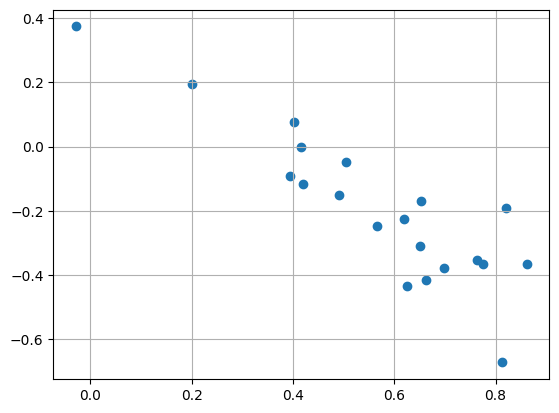

In [65]:
import matplotlib.pyplot as plt
plt.scatter(mms_shifts[mms_shifts["location_id"] == LOCATION_DATA["nigeria"]].shift1, mms_shifts[mms_shifts["location_id"] == LOCATION_DATA["nigeria"]].shift2)
plt.grid()

In [66]:
mms_shifts.to_csv('updated_mms_shifts.csv')

In [73]:
# ok, now for some validation
mms_exp_val = covered_exp.merge(mms_shifts, on=['draw','location_id'])
mms_exp_val['ga_start'] = mms_exp_val.ga_start + mms_exp_val.shift1
mms_exp_val['ga_end'] = mms_exp_val.ga_end + mms_exp_val.shift1
mms_exp_val['frac_shift2'] = np.where(mms_exp_val.ga_start < (32 - mms_exp_val.shift2), 0, 1)
mms_exp_val['ga_start'] = mms_exp_val.ga_start + (mms_exp_val.shift2 * mms_exp_val.frac_shift2)
mms_exp_val['ga_end'] = mms_exp_val.ga_end + (mms_exp_val.shift2 * mms_exp_val.frac_shift2)

mms_exp_val['exposure_vptb'] = np.where(mms_exp_val.ga_start >= 32, 0,
                                            np.where(mms_exp_val.ga_end < 32, mms_exp_val.exposure,
                                                    ((32 - mms_exp_val.ga_start)/(mms_exp_val.ga_end - mms_exp_val.ga_start)
                                                     * mms_exp_val.exposure)))
mms_exp_val['exposure_ptb'] = np.where(mms_exp_val.ga_start >= 37, 0,
                                        np.where(mms_exp_val.ga_end < 37, mms_exp_val.exposure,
                                                ((37 - mms_exp_val.ga_start)/(mms_exp_val.ga_end - mms_exp_val.ga_start)
                                                 *mms_exp_val.exposure)))
mms_exp_val = mms_exp_val.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]
mms_exp_val

exposure_ptb  exposure_vptb
location_id draw                                 
165         draw_109      0.138046       0.027725
            draw_114      0.134778       0.023275
            draw_115      0.149944       0.026363
            draw_118      0.141457       0.024751
            draw_127      0.136904       0.025873
            draw_146      0.147618       0.022295
            draw_156      0.136999       0.022941
            draw_167      0.143907       0.024774
            draw_170      0.133071       0.022831
            draw_178      0.149097       0.030702
            draw_197      0.140072       0.023782
            draw_22       0.144625       0.023693
            draw_244      0.137468       0.027532
            draw_26       0.136549       0.026624
            draw_28       0.139311       0.022632
            draw_35       0.143010       0.023446
            draw_60       0.137635       0.025105
            draw_71       0.141387       0.025631
            draw_79       0.142388       0.026784
            draw_94       0.139043       0.025218
179         draw_109      0.125382       0.023341
            draw_114      0.119644       0.018468
            draw_115      0.124991       0.020110
            draw_118      0.127605       0.019790
            draw_127      0.127749       0.020898
            draw_146      0.128818       0.016974
            draw_156      0.126511       0.019291
            draw_167      0.131268       0.019798
            draw_170      0.114787       0.017869
            draw_178      0.128607       0.023869
            draw_197      0.129761       0.018904
            draw_22       0.127441       0.019132
            draw_244      0.119588       0.021303
            draw_26       0.126330       0.018577
            draw_28       0.118797       0.016442
            draw_35       0.135785       0.019350
            draw_60       0.128448       0.018942
            draw_71       0.127553       0.018945
            draw_79       0.135255       0.022490
            draw_94       0.134772       0.023243
214         draw_109      0.124167       0.022199
            draw_114      0.119220       0.019046
            draw_115      0.128772       0.021407
            draw_118      0.130019       0.021584
            draw_127      0.126350       0.020651
            draw_146      0.130439       0.017686
            draw_156      0.129685       0.019714
            draw_167      0.131513       0.021918
            draw_170      0.120898       0.021163
            draw_178      0.126602       0.026004
            draw_197      0.129842       0.020562
            draw_22       0.129062       0.020370
            draw_244      0.120683       0.022303
            draw_26       0.125007       0.022164
            draw_28       0.124623       0.020278
            draw_35       0.136404       0.022019
            draw_60       0.131575       0.020837
            draw_71       0.131015       0.022721
            draw_79       0.130181       0.021646
            draw_94       0.125607       0.022194

In [74]:
rrs = mms_exp_val / covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]
rrs

exposure_ptb  exposure_vptb
location_id draw                                 
165         draw_109      0.890192       0.937986
            draw_114      0.873632       0.770660
            draw_115      0.921385       0.871358
            draw_118      0.903466       0.811109
            draw_127      0.880826       0.818911
            draw_146      0.960322       0.744831
            draw_156      0.897113       0.753376
            draw_167      0.917379       0.837992
            draw_170      0.848085       0.772676
            draw_178      0.914434       1.007100
            draw_197      0.936444       0.814610
            draw_22       0.944482       0.832032
            draw_244      0.876311       0.878986
            draw_26       0.890517       0.842140
            draw_28       0.897406       0.771426
            draw_35       0.925817       0.801571
            draw_60       0.908491       0.854672
            draw_71       0.913209       0.810886
            draw_79       0.916559       0.884711
            draw_94       0.896478       0.876818
179         draw_109      0.890193       0.937987
            draw_114      0.873632       0.770661
            draw_115      0.921385       0.871359
            draw_118      0.903466       0.811109
            draw_127      0.880826       0.818911
            draw_146      0.960322       0.744831
            draw_156      0.897113       0.753377
            draw_167      0.917379       0.837992
            draw_170      0.848086       0.772676
            draw_178      0.914435       1.012090
            draw_197      0.936444       0.814610
            draw_22       0.944482       0.832032
            draw_244      0.876311       0.878986
            draw_26       0.890517       0.842140
            draw_28       0.897406       0.771426
            draw_35       0.925817       0.801571
            draw_60       0.908491       0.854672
            draw_71       0.913208       0.810886
            draw_79       0.916560       0.884712
            draw_94       0.896479       0.876817
214         draw_109      0.890192       0.937987
            draw_114      0.873632       0.770661
            draw_115      0.921385       0.871359
            draw_118      0.903466       0.811110
            draw_127      0.880826       0.818910
            draw_146      0.960321       0.744832
            draw_156      0.897113       0.753377
            draw_167      0.917378       0.837993
            draw_170      0.848086       0.772676
            draw_178      0.914434       0.999769
            draw_197      0.936444       0.814611
            draw_22       0.944483       0.832032
            draw_244      0.876312       0.878986
            draw_26       0.890517       0.842140
            draw_28       0.897406       0.771427
            draw_35       0.925817       0.801571
            draw_60       0.908491       0.854672
            draw_71       0.913209       0.810886
            draw_79       0.916560       0.884711
            draw_94       0.896479       0.876818

In [75]:
# IRA OR: 0.9 (0.86, 0.95) relative to no IFA
# MMS RR: 0.91 (0.84, 0.99) relative to IFA... UPDATED FROM: 0.95 (0.90, 1.01) relative to IFA
# MMS VERY PRETERM: RR = 0.81 (0.71, 0.93) relative to IFA
# from https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/oral_iron_antenatal/oral_iron_antenatal.html#id27


print('Validation target is: ',mms_pt_rr_draws.rr.mean().round(3),
      ' (95% CI: ',mms_pt_rr_draws.rr.quantile(0.025).round(3), 
      ", ",mms_pt_rr_draws.rr.quantile(0.975).round(3), ")")
rrs.describe(percentiles=[0.025,0.975]).exposure_ptb.filter(['mean','2.5%','97.5%'])

Validation target is:  0.912  (95% CI:  0.84 ,  0.987 )


mean     0.905628
2.5%     0.848086
97.5%    0.960322
Name: exposure_ptb, dtype: float64

In [76]:
print('Validation target is: ',mms_vpt_rr_draws.rr.mean().round(3),
      ' (95% CI: ',mms_vpt_rr_draws.rr.quantile(0.025).round(3), 
      ", ",mms_vpt_rr_draws.rr.quantile(0.975).round(3), ")")
rrs.describe(percentiles=[0.025,0.975]).exposure_vptb.filter(['mean','2.5%','97.5%'])

Validation target is:  0.813  (95% CI:  0.706 ,  0.936 )


mean     0.834654
2.5%     0.744832
97.5%    1.003617
Name: exposure_vptb, dtype: float64